## Train and explain a model

Note that this is a small sample of the whole data for demonstration purpose.

In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle

from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/Ziqi-Li/geoshapley/refs/heads/main/data/seattle_sample_1k.csv")

In [3]:
data = gpd.GeoDataFrame(
    data, crs="EPSG:32610", geometry=gpd.points_from_xy(x=data.UTM_X, y=data.UTM_Y))

In [4]:
y = data.log_price

X_coords = data[['bathrooms', 'sqft_living', 'sqft_lot', 'grade', 'condition',
                 'waterfront', 'view', 'age','UTM_X', 'UTM_Y']]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_coords, y, random_state=1)

## Model training by AutoML

In [6]:
from flaml import AutoML

settings = {
    "time_budget": 20,  # total running time in seconds
    "metric": 'r2',  # primary metrics for regression can be chosen from: ['mae','mse','r2','rmse','mape']
    "estimator_list": 'auto',  # list of ML learners; 'auto' means try all
    "task": 'regression',  # task type, can also be classification   
    "eval_method": 'cv', #enable cross-validation
    "n_splits": 5, #5-fold cross validation
    "verbose": 3
}

automl = AutoML()
automl.fit(X_train, y_train,  **settings)

[flaml.automl.logger: 04-09 12:58:46] {1728} INFO - task = regression
[flaml.automl.logger: 04-09 12:58:46] {1739} INFO - Evaluation method: cv
[flaml.automl.logger: 04-09 12:58:46] {1838} INFO - Minimizing error metric: 1-r2
[flaml.automl.logger: 04-09 12:58:46] {1955} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd', 'catboost']
[flaml.automl.logger: 04-09 12:58:46] {2258} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 04-09 12:58:46] {2393} INFO - Estimated sufficient time budget=340s. Estimated necessary time budget=3s.
[flaml.automl.logger: 04-09 12:58:46] {2442} INFO -  at 0.1s,	estimator lgbm's best error=0.6609,	best estimator lgbm's best error=0.6609
[flaml.automl.logger: 04-09 12:58:46] {2258} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 04-09 12:58:46] {2442} INFO -  at 0.1s,	estimator lgbm's best error=0.6609,	best estimator lgbm's best error=0.6609
[flaml.automl.logger: 04-09 12:58:4

[flaml.automl.logger: 04-09 12:58:52] {2258} INFO - iteration 34, current learner rf
[flaml.automl.logger: 04-09 12:58:52] {2442} INFO -  at 6.1s,	estimator rf's best error=0.1907,	best estimator catboost's best error=0.1367
[flaml.automl.logger: 04-09 12:58:52] {2258} INFO - iteration 35, current learner catboost
[flaml.automl.logger: 04-09 12:58:53] {2442} INFO -  at 7.4s,	estimator catboost's best error=0.1367,	best estimator catboost's best error=0.1367
[flaml.automl.logger: 04-09 12:58:53] {2258} INFO - iteration 36, current learner lgbm
[flaml.automl.logger: 04-09 12:58:54] {2442} INFO -  at 8.2s,	estimator lgbm's best error=0.1489,	best estimator catboost's best error=0.1367
[flaml.automl.logger: 04-09 12:58:54] {2258} INFO - iteration 37, current learner xgboost
[flaml.automl.logger: 04-09 12:58:54] {2442} INFO -  at 8.2s,	estimator xgboost's best error=0.2571,	best estimator catboost's best error=0.1367
[flaml.automl.logger: 04-09 12:58:54] {2258} INFO - iteration 38, current 

[flaml.automl.logger: 04-09 12:59:01] {2258} INFO - iteration 69, current learner xgb_limitdepth
[flaml.automl.logger: 04-09 12:59:01] {2442} INFO -  at 15.1s,	estimator xgb_limitdepth's best error=0.1680,	best estimator catboost's best error=0.1354
[flaml.automl.logger: 04-09 12:59:01] {2258} INFO - iteration 70, current learner xgb_limitdepth
[flaml.automl.logger: 04-09 12:59:01] {2442} INFO -  at 15.2s,	estimator xgb_limitdepth's best error=0.1680,	best estimator catboost's best error=0.1354
[flaml.automl.logger: 04-09 12:59:01] {2258} INFO - iteration 71, current learner lgbm
[flaml.automl.logger: 04-09 12:59:01] {2442} INFO -  at 15.5s,	estimator lgbm's best error=0.1435,	best estimator catboost's best error=0.1354
[flaml.automl.logger: 04-09 12:59:01] {2258} INFO - iteration 72, current learner xgb_limitdepth
[flaml.automl.logger: 04-09 12:59:01] {2442} INFO -  at 15.6s,	estimator xgb_limitdepth's best error=0.1680,	best estimator catboost's best error=0.1354
[flaml.automl.logger

In [7]:
auto_pred = automl.predict(X_test)

from sklearn.metrics import r2_score
r2_score(y_test, auto_pred)

0.8499538586776917

In [8]:
automl.model.estimator

In [9]:

from geoshapley import GeoShapleyExplainer

In [10]:
import shap

#It is suggested to use a small representative samples as background
#This can be randomly chosen, or as shown here, using k-means

background_X = shap.kmeans(X_coords,k=10).data

In [11]:
%%time
automl_explainer = GeoShapleyExplainer(automl.model.estimator.predict, background_X)

rslt = automl_explainer.explain(X_coords, n_jobs=-1)

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 388 ms, sys: 319 ms, total: 707 ms
Wall time: 4.62 s


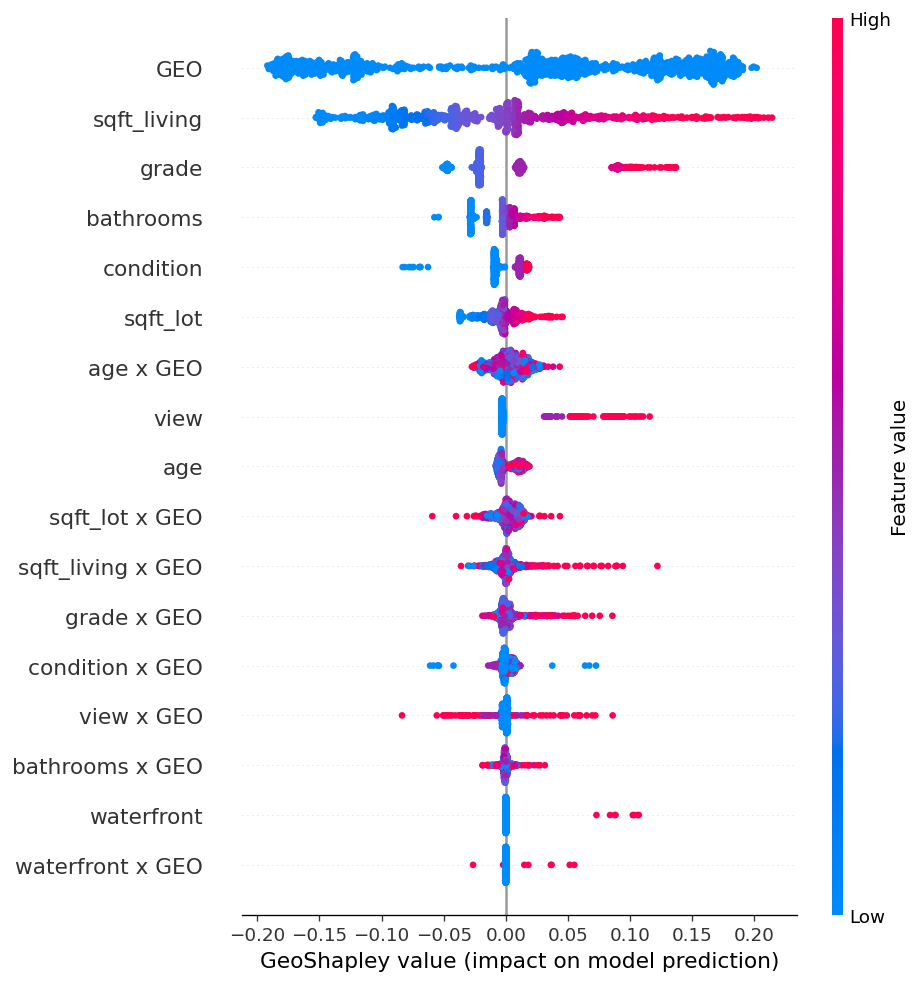

In [12]:
rslt.summary_plot(dpi=120)

In [13]:
rslt.summary_statistics()

,min,25%,50%,75%,max,mean,std,abs. mean
GEO,-1.918621e-01,-1.165064e-01,4.267199e-02,1.333950e-01,0.201831,0.021001,0.122803,0.111018
sqft_living,-1.527960e-01,-6.762087e-02,-1.130913e-02,3.484710e-02,0.214175,-0.011258,0.078191,0.062834
grade,-5.107948e-02,-2.184197e-02,-2.075347e-02,1.181074e-02,0.136774,0.002345,0.044946,0.033776
bathrooms,-5.752622e-02,-1.553133e-02,-1.267599e-03,6.497286e-03,0.043412,-0.002463,0.016903,0.012709
condition,-8.306644e-02,-9.149960e-03,-7.891638e-03,1.113896e-02,0.018884,-0.001290,0.012696,0.010722
sqft_lot,-3.756062e-02,-9.166429e-03,-2.532287e-03,5.420255e-03,0.045625,-0.002815,0.013106,0.009701
age x GEO,-2.730335e-02,-3.912772e-03,2.989920e-03,1.163194e-02,0.043324,0.002988,0.011617,0.009560
view,-3.346043e-03,-2.978793e-03,-2.850877e-03,-2.621648e-03,0.115729,0.003761,0.021668,0.008927
age,-8.188491e-03,-4.710997e-03,-2.120738e-03,9.869095e-03,0.019070,0.001967,0.007729,0.006946
sqft_lot x GEO,-5.919406e-02,-1.114935e-03,2.793861e-03,8.582416e-03,0.043539,0.002618,0.008583,0.006859


In [14]:
rslt.check_additivity()

Components add up to model prediction:  True


### Location invariant primary effects

100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


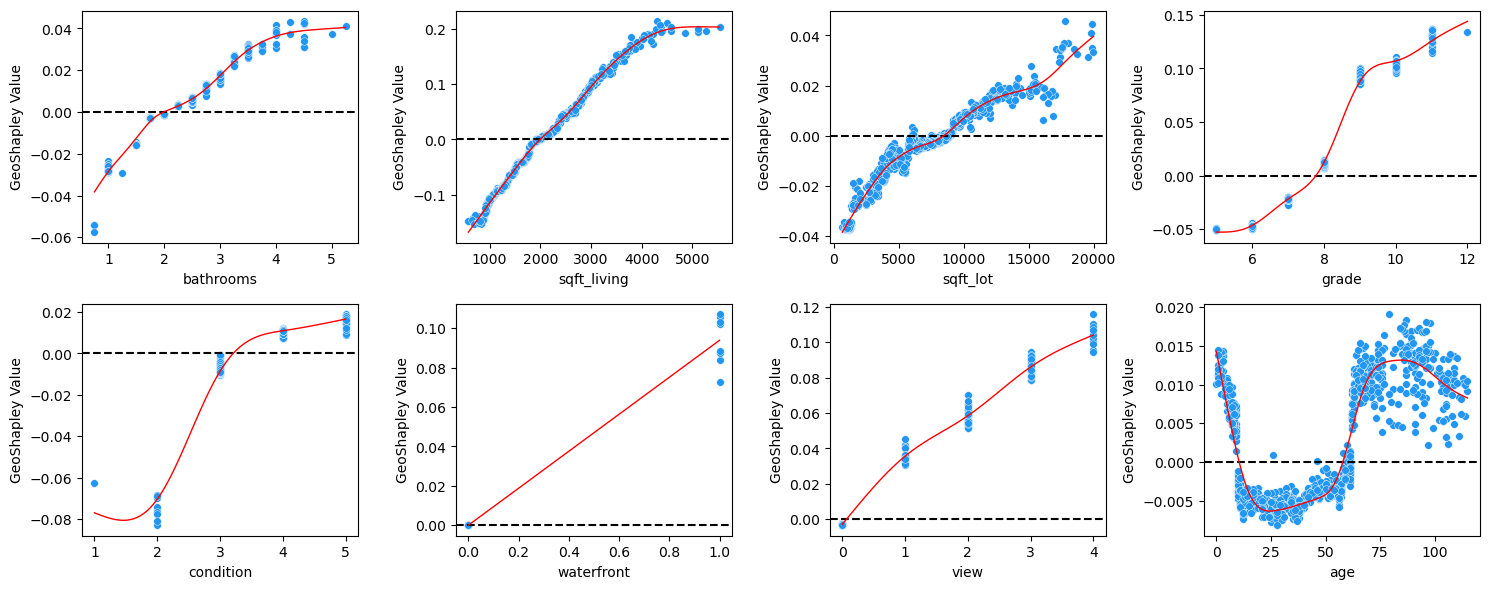

In [15]:
rslt.partial_dependence_plots(figsize=(15,6),max_cols=4,gam_curve=True,s=30)

In [16]:
coords = data[['UTM_X','UTM_Y']].values

## Calculate Spatially Varying Coefficients from GeoShapley values

SVCs are smoothed using GWR.

In [17]:
#if include_primary is set to True, the spatially varying effects will contain the above non-linear effects.
svc = rslt.get_svc(col = [0,1,2,3,4,5,6,7], coef_type="gwr", include_primary=False, coords=coords)

In [18]:
X_coords.columns

Index(['bathrooms', 'sqft_living', 'sqft_lot', 'grade', 'condition',
       'waterfront', 'view', 'age', 'UTM_X', 'UTM_Y'],
      dtype='object')

In [19]:
import contextily as cx

### Intrinsic location effect

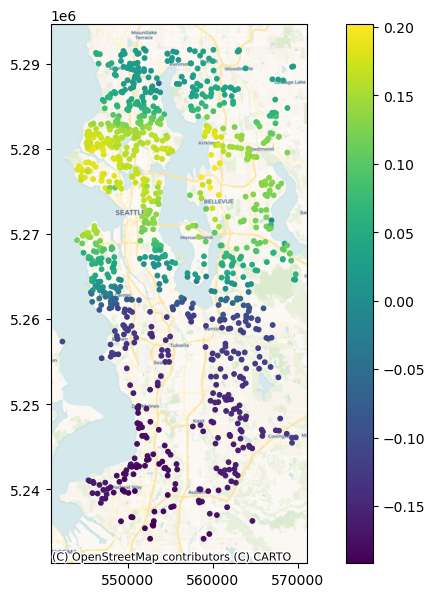

In [20]:
fig, ax = plt.subplots(1, 1,figsize=(10,7),dpi=100)

data.plot(ax=ax,column=rslt.geo,
                  s=10,figsize=(10,10),legend=True)

cx.add_basemap(ax, source=cx.providers.CartoDB.Voyager, crs=data.crs,zoom=11)

### Spatially varying coefficient for sqft_living (after removing global primary effect)

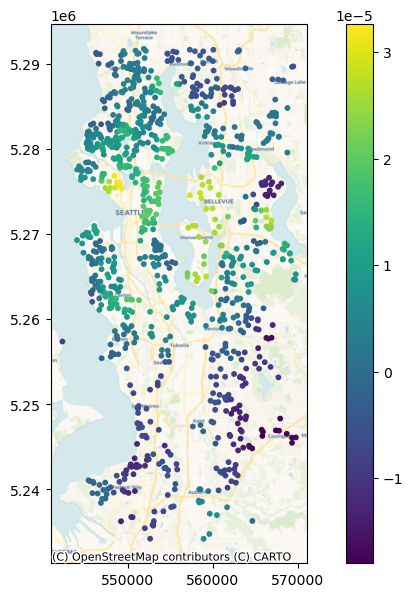

In [21]:
fig, ax = plt.subplots(1, 1,figsize=(10,7),dpi=100)

data.plot(ax=ax,column=svc[:,1],
                  s=10,figsize=(10,10),legend=True)

cx.add_basemap(ax, source=cx.providers.CartoDB.Voyager, crs=data.crs,zoom=11)

### Spatially varying coefficient for age (after removing global primary effect)

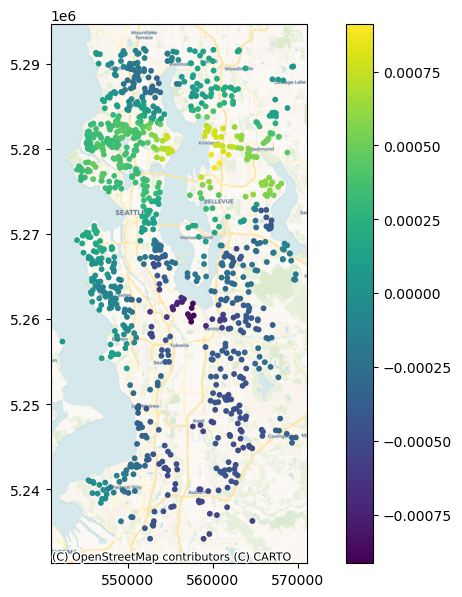

In [22]:
fig, ax = plt.subplots(1, 1,figsize=(10,7),dpi=100)

data.plot(ax=ax,column=svc[:,7],
                  s=10,figsize=(10,10),legend=True)

cx.add_basemap(ax, source=cx.providers.CartoDB.Voyager, crs=data.crs,zoom=11)

### Spatially varying coefficient for waterfront (after removing global primary effect)

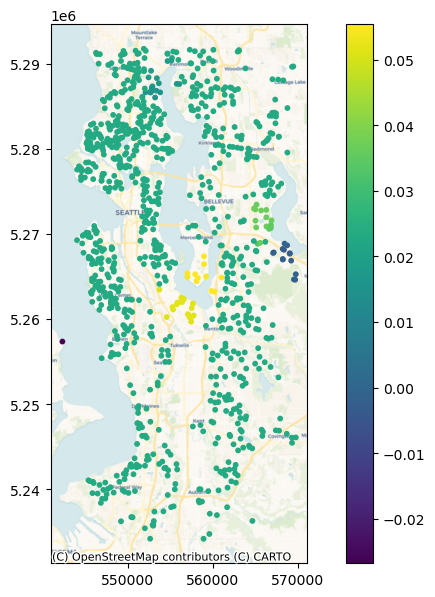

In [23]:
fig, ax = plt.subplots(1, 1,figsize=(10,7),dpi=100)

data.plot(ax=ax,column=svc[:,5],
                  s=10,figsize=(10,10),legend=True)

cx.add_basemap(ax, source=cx.providers.CartoDB.Voyager, crs=data.crs,zoom=11)